In [1]:
import numpy as np
import starry

import theano
theano.config.gcc__cxxflags += " -fexceptions"

starry.config.lazy = False
starry.config.quiet = True

Note: Keep in mind, however, that the primary object is assumed to sit at the origin, and the secondary objects are assumed to be massless.

Creating a Star

In [2]:
#Creating a star
star = starry.Primary(starry.Map(ydeg=5, udeg=2, amp=1.0), m=1.0, r=1.0, prot=1.0)

star.map[1] = 0.40
star.map[2] = 0.26

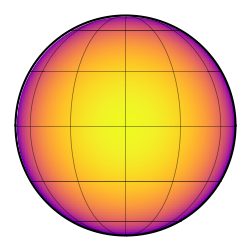

In [3]:
star.map.show()

In [4]:
star.map.y

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [5]:
#Creating a planet - a hot jupiter in this case

planet = starry.kepler.Secondary(
    starry.Map(ydeg=5, amp=5e-3),  # the surface map
    m=0,  # mass in solar masses
    r=0.1,  # radius in solar radii
    porb=1.0,  # orbital period in days
    prot=1.0,  # rotation period in days (synchronous)
    Omega=30,  # longitude of ascending node in degrees
    ecc=0.3,  # eccentricity
    w=30,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

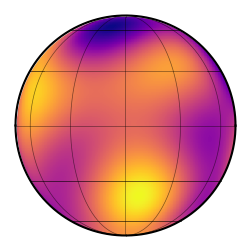

In [6]:
np.random.seed(123)
planet.map[1:, :] = 0.01 * np.random.randn(planet.map.Ny - 1)
planet.map.show()

In [7]:
planet.map.minimize()

(63.14152819709035, -16.776160764628425, 0.0013165107708421693)

In [8]:
#Creating a system
# system = starry.System(star, planet, texp=300/(24*3600))
system = starry.System(star, planet)

In [9]:
#time
time = np.linspace(-0.25, 3.25, 10000)
flux_system = system.flux(time)

In [10]:
%%time
time = np.linspace(-0.25, 3.25, 10000)
flux_system = system.flux(time)

CPU times: user 1.34 s, sys: 7.01 s, total: 8.35 s
Wall time: 67.2 ms


In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'system flux')

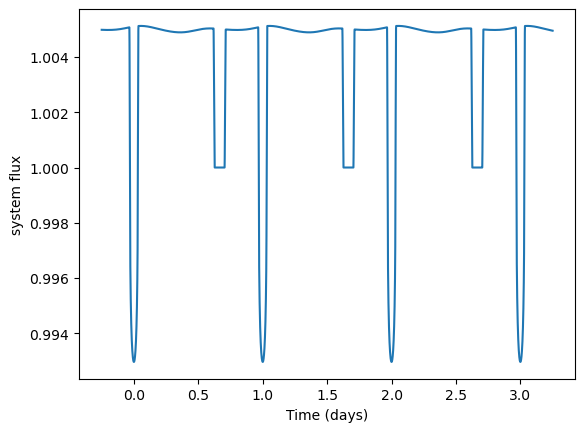

In [12]:
plt.plot(time, flux_system)
plt.xlabel("Time (days)")
plt.ylabel("system flux")

# Calculating the stellar and planetary light curves individually

In [13]:
flux_star, flux_planet = system.flux(time, total=False)

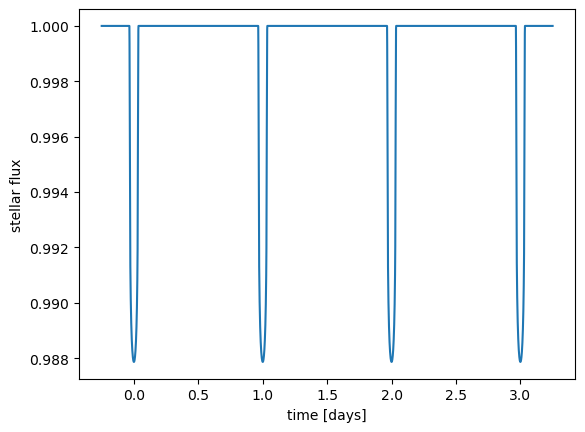

In [14]:
plt.plot(time, flux_star)
plt.xlabel("time [days]")
plt.ylabel("stellar flux");

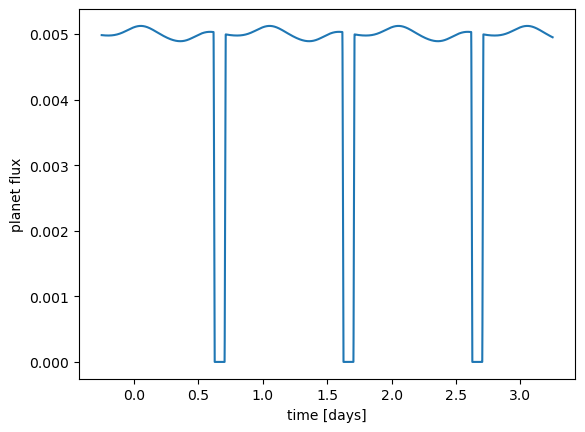

In [15]:
plt.plot(time, flux_planet)
plt.xlabel("time [days]")
plt.ylabel("planet flux");

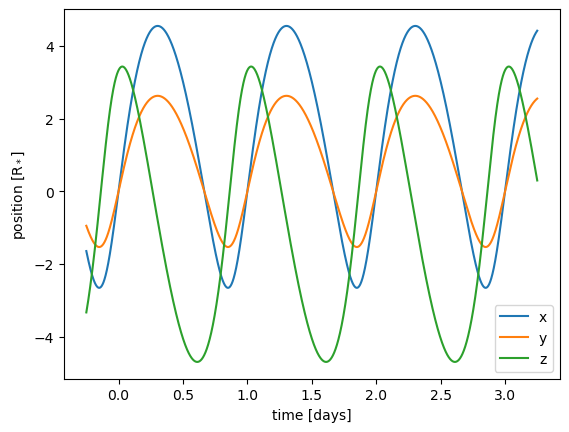

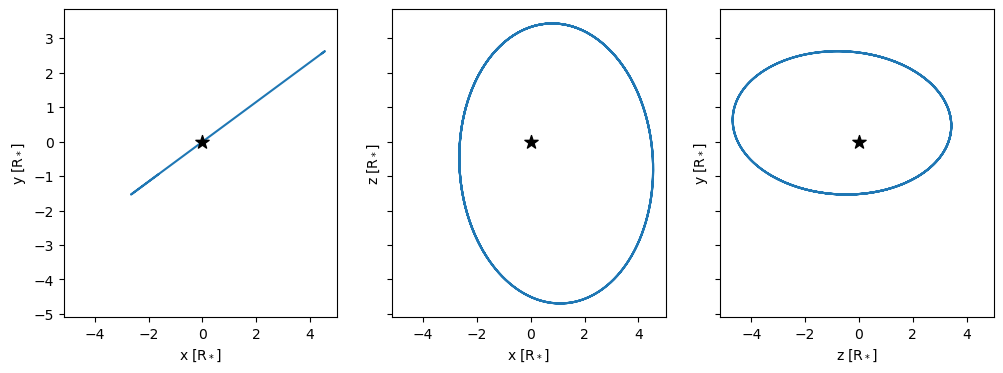

In [16]:
# Planets orbit

x, y, z = system.position(time)

plt.plot(time, x[1], label="x")
plt.plot(time, y[1], label="y")
plt.plot(time, z[1], label="z")
plt.ylabel("position [R$_*$]")
plt.xlabel("time [days]")
plt.legend()


fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
ax[0].plot(x[1], y[1])
ax[1].plot(x[1], z[1])
ax[2].plot(z[1], y[1])
for n in [0, 1, 2]:
    ax[n].scatter(0, 0, marker="*", color="k", s=100, zorder=10)
ax[0].set_xlabel(r"x [R$_*$]")
ax[0].set_ylabel(r"y [R$_*$]")
ax[1].set_xlabel(r"x [R$_*$]")
ax[1].set_ylabel(r"z [R$_*$]")
ax[2].set_xlabel(r"z [R$_*$]")
ax[2].set_ylabel(r"y [R$_*$]");

In [17]:
planet.r = 0.33
system.show(t=np.linspace(0, 2, 100), window_pad=4, figsize=(8, 8))

Comparison to batman

In [18]:
#Define the systems parameters
u1 = 0.4  # Stellar linear limb darkening coefficient
u2 = 0.26  # Stellar quadratic limb darkening coefficient
rplanet = 0.1  # Planet radius in units of stellar radius
inc = 89.95  # Planet orbital inclination
per = 50  # Planet orbital period in days
mstar = 1  # Stellar mass in Msun
rstar = 1  # Stellar radius in Rsun
a = (per ** 2 * starry._constants.G_grav * mstar / (4 * np.pi ** 2)) ** (
    1.0 / 3.0
)  # semi-major axis in Rsun

#Time grid to evaluate on
npts = 500
time = np.linspace(-0.3, 0.3, npts)

#Evaluating the starry lightcurve
# Instantiate the star
star = starry.Primary(starry.Map(udeg=2))
star.map[1] = u1
star.map[2] = u2

# Instantiate the planet
planet = starry.kepler.Secondary(starry.Map(amp=0), m=0, porb=per, inc=inc, r=rplanet)

# Instantiate the system
system = starry.System(star, planet)

# Compute and store the light curve
flux_starry = system.flux(time)

In [19]:
#Batman lightcurve to compare
import batman

params = batman.TransitParams()
params.limb_dark = "quadratic"
params.u = [u1, u2]
params.t0 = 0.0
params.ecc = 0.0
params.w = 90.0
params.rp = rplanet
params.a = a
params.per = per
params.inc = inc
m = batman.TransitModel(params, time)
flux_batman = m.light_curve(params)

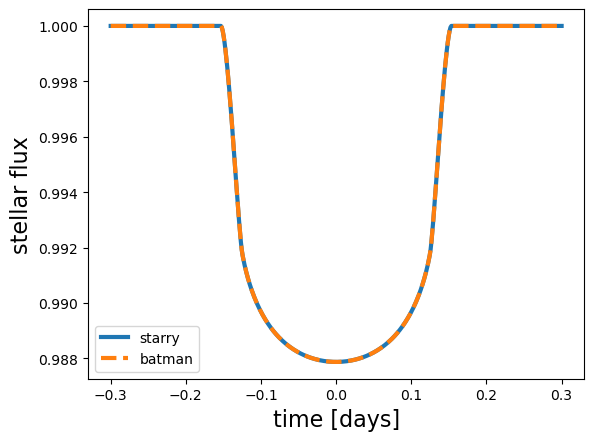

In [20]:
#Plotting the two lightcurves
plt.plot(time, flux_starry, label="starry", lw=3)
plt.plot(time, flux_batman, "--", label="batman", lw=3)
plt.xlabel("time [days]", fontsize=16)
plt.ylabel("stellar flux", fontsize=16)
plt.legend()

Text(0, 0.5, 'residuals')

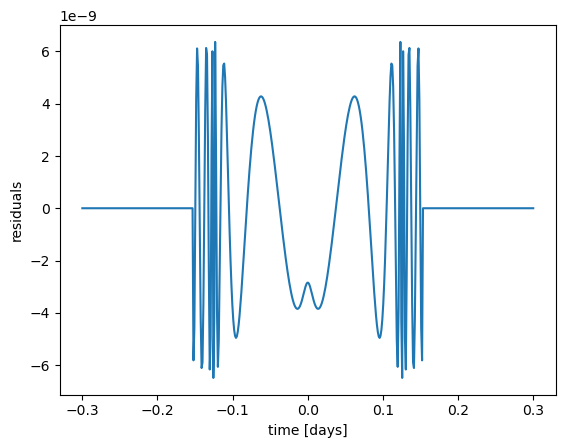

In [21]:
#difference
plt.plot(time, flux_starry - flux_batman)
plt.xlabel("time [days]")
plt.ylabel("residuals")